# Convolve 3.0

## Problem Statement:

You have been provided with a random sample of **96,806** Credit Card details in  
“Dev_data_to_be_shared.zip”, along with a flag **(bad_flag)** henceforth known as “development 
data”.<br>
This is a historical snapshot of the Credit Card portfolio of Bank A. <br>
**Credit Cards that have actually defaulted have bad_flag = 1.**<br>
You have also been provided with several independent variables.<br>

These include: <br>
- On us attributes like credit limit (varables with names starting with onus_attributes) 
- Transaction level attributes like number of transactions / rupee value transactions on 
various kinds of merchants (variables with names starting with transaction_attribute) 
- Bureau tradeline level attributes (like product holdings, historical delinquencies) – variables 
starting with bureau 
- Bureau enquiry level attributes (like PL enquiries in the last 3 months etc) – variables 
starting with bureau_enquiry.

You have also been provided with another random sample of 41,792 Credit Card details in “validation_data_to_be_shared.zip” with the same set of input variables, but without “bad_flag”. <br>
This will be referred to going forward as “validation data”.

**Your objective is to develop the **Behaviour Score** for Bank A.**

Bank A issues Credit Cards to eligible customers. The Bank deploys advanced ML models and frameworks to decide on eligibility, limit, and interest rate assignment. <br>
The models and frameworks are optimized to manage early risk and ensure profitability.  <br>
The Bank has now decided to build a robust risk management framework for its existing Credit Card customers, irrespective of when they were acquired. <br>
To enable this, the Bank has decided to create a **“Behaviour Score”**. A Behaviour Score is a predictive model. It is developed on a base of customers whose Credit Cards are **open** and are **not past due**. <br>
<br><br>
The model predicts the probability of customers defaulting on the Credit Cards going forward. <br><br>
This model will then be used for several portfolio risk management activities

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.decomposition import PCA

from imblearn.over_sampling import SMOTE

## EDA

### Read the dataset from the filesystem

In [2]:
card_data = pd.read_csv('./data/Dev_data_to_be_shared.csv')

In [3]:
print(card_data.shape)
card_data.head()

(96806, 1216)


,account_number,bad_flag,onus_attribute_1,transaction_attribute_1,transaction_attribute_2,transaction_attribute_3,transaction_attribute_4,transaction_attribute_5,transaction_attribute_6,transaction_attribute_7,...,bureau_enquiry_47,bureau_enquiry_48,bureau_enquiry_49,bureau_enquiry_50,onus_attribute_43,onus_attribute_44,onus_attribute_45,onus_attribute_46,onus_attribute_47,onus_attribute_48
0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,0,221000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,0,25000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,8.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,0,86000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,30.0,NaN,NaN,NaN,NaN,NaN,NaN
4,5,0,215000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
card_data = card_data.dropna(axis = 1, how = 'all')

In [5]:
X = card_data.drop('bad_flag', axis = 1)
y = card_data['bad_flag']

In [6]:
# Collect columns starting with 'onus', 'transaction', and 'bureau' in separate variables
onus_attr_X = X.filter(like='onus_attribute')
transaction_attr_X = X.filter(like='transaction_attribute')
bureau_attr_X = X.filter(like='bureau')

# Perform mean imputation for onus attributes
imputer_onus = SimpleImputer(strategy='mean')
onus_attr_X_imputed = imputer_onus.fit_transform(onus_attr_X)

# Convert the imputed array back to DataFrame
onus_attr_X_imputed_df = pd.DataFrame(data=onus_attr_X_imputed, columns=onus_attr_X.columns)

# Perform mean imputation for transaction attributes
imputer_transaction = SimpleImputer(strategy='mean')
transaction_attr_X_imputed = imputer_transaction.fit_transform(transaction_attr_X)

# Convert the imputed array back to DataFrame
transaction_attr_X_imputed_df = pd.DataFrame(data=transaction_attr_X_imputed, columns=transaction_attr_X.columns)

# Perform mean imputation for bureau attributes
imputer_bureau = SimpleImputer(strategy='mean')
bureau_attr_X_imputed = imputer_bureau.fit_transform(bureau_attr_X)

# Convert the imputed array back to DataFrame
bureau_attr_X_imputed_df = pd.DataFrame(data=bureau_attr_X_imputed, columns=bureau_attr_X.columns)

# Concatenate the DataFrames
X_selected = pd.concat([onus_attr_X_imputed_df, transaction_attr_X_imputed_df, bureau_attr_X_imputed_df], axis=1)

# Print the shape of the new DataFrame
print(X_selected.shape)
print(X.shape)
print(onus_attr_X.shape, transaction_attr_X.shape, bureau_attr_X.shape)

(96806, 1212)
(96806, 1213)
(96806, 48) (96806, 664) (96806, 500)


In [7]:
# Concatenate y with the selected attributes
y_onus_attr_X = pd.concat([y, onus_attr_X_imputed_df], axis=1)
y_transaction_attr_X = pd.concat([y, transaction_attr_X_imputed_df], axis=1)
y_bureau_attr_X = pd.concat([y, bureau_attr_X_imputed_df], axis=1)

# Calculate correlation matrix for each DataFrame
corr_onus_attr_X = y_onus_attr_X.corr()
corr_transaction_attr_X = y_transaction_attr_X.corr()
corr_bureau_attr_X = y_bureau_attr_X.corr()

<Axes: >

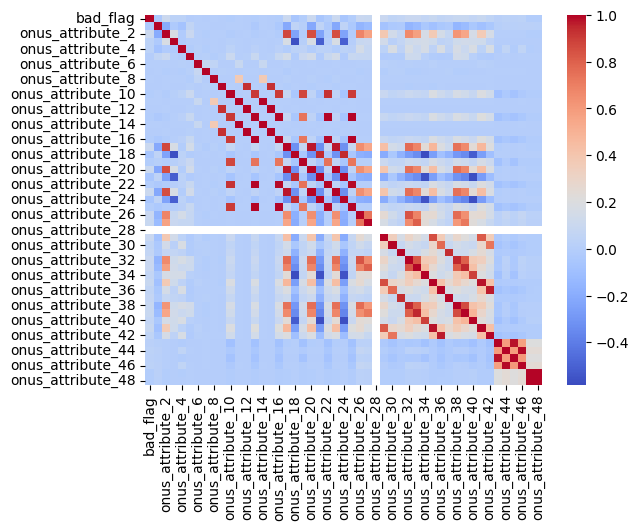

In [8]:
sns.heatmap(corr_onus_attr_X, cmap='coolwarm', annot=False)

<Axes: >

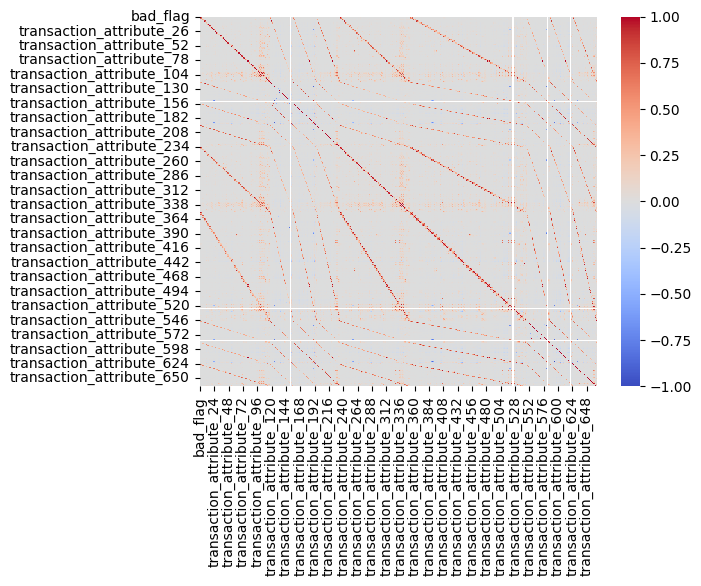

In [9]:
sns.heatmap(corr_transaction_attr_X, cmap='coolwarm', annot=False)

<Axes: >

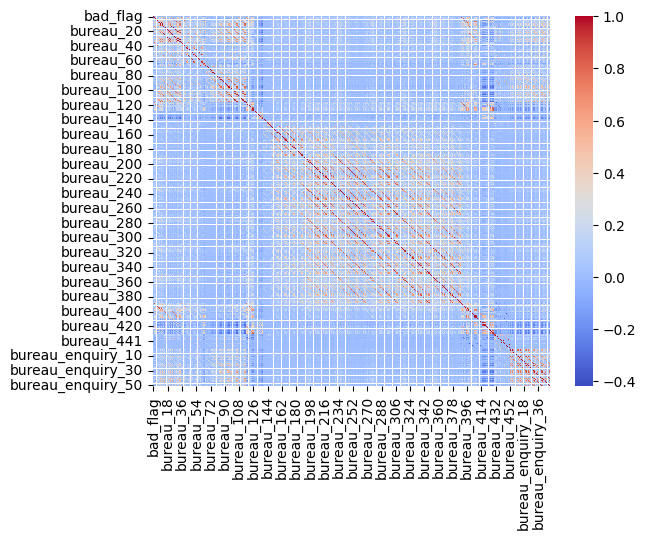

In [10]:
sns.heatmap(corr_bureau_attr_X, cmap='coolwarm', annot=False)

<Axes: >

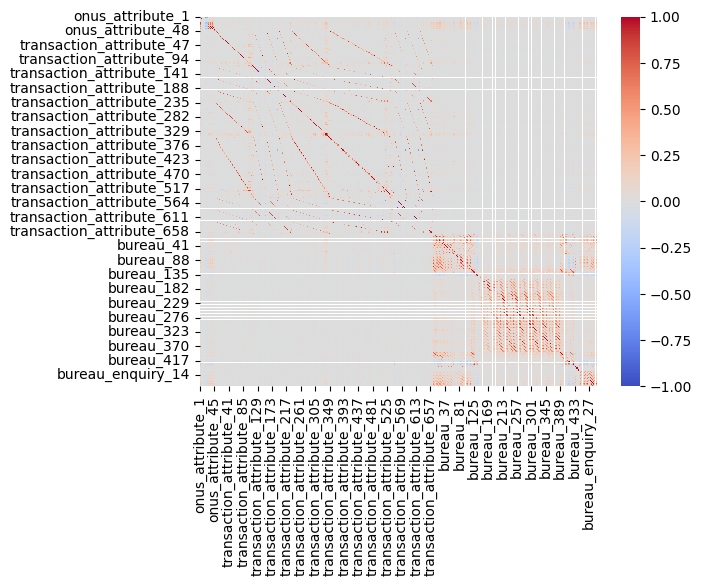

In [11]:
sns.heatmap(X_selected.corr(), cmap='coolwarm', annot=False)

In [12]:
# Calculate mean, std deviation, min, max, sum, and total NaN count for onus attributes
onus_attr_stats = onus_attr_X_imputed_df.agg(['mean', 'std', 'min', 'max', 'sum', 'count']).transpose()
onus_attr_stats['NaN_count'] = onus_attr_X_imputed_df.isnull().sum()

# Calculate mean, std deviation, min, max, sum, and total NaN count for transaction attributes
transaction_attr_stats = transaction_attr_X_imputed_df.agg(['mean', 'std', 'min', 'max', 'sum', 'count']).transpose()
transaction_attr_stats['NaN_count'] = transaction_attr_X_imputed_df.isnull().sum()

# Calculate mean, std deviation, min, max, sum, and total NaN count for bureau attributes
bureau_attr_stats = bureau_attr_X_imputed_df.agg(['mean', 'std', 'min', 'max', 'sum', 'count']).transpose()
bureau_attr_stats['NaN_count'] = bureau_attr_X_imputed_df.isnull().sum()

In [13]:
onus_attr_stats

,mean,std,min,max,sum,count,NaN_count
onus_attribute_1,154239.119804,148749.643731,2.500000e+04,2.800000e+06,1.493127e+10,96806.0,0
onus_attribute_2,0.223953,0.315112,-1.090172e+00,1.243536e+00,2.167998e+04,96806.0,0
onus_attribute_3,0.004442,0.066500,0.000000e+00,1.000000e+00,4.300000e+02,96806.0,0
onus_attribute_4,0.104208,0.305532,0.000000e+00,1.000000e+00,1.008800e+04,96806.0,0
onus_attribute_5,13651.141877,75221.096783,0.000000e+00,1.449062e+07,1.321512e+09,96806.0,0
onus_attribute_6,-1297.654162,50185.743339,-8.836500e+06,5.834018e+06,-1.256207e+08,96806.0,0
onus_attribute_7,142.367293,4204.701786,-1.290306e-03,7.256470e+05,1.378201e+07,96806.0,0
onus_attribute_8,-107.851063,6595.141913,-1.622450e+06,9.395292e+04,-1.044063e+07,96806.0,0
onus_attribute_9,39.836408,2110.874332,-2.823981e-03,5.811266e+05,3.856403e+06,96806.0,0
onus_attribute_10,2.341711,0.815388,1.000000e+00,4.000000e+00,2.266917e+05,96806.0,0


In [14]:
transaction_attr_stats

,mean,std,min,max,sum,count,NaN_count
transaction_attribute_1,9.570769,1301.803184,0.000000,398936.791000,9.265079e+05,96806.0,0
transaction_attribute_2,0.002207,0.102530,0.000000,25.000000,2.136968e+02,96806.0,0
transaction_attribute_3,4.092854,259.317693,0.000000,55000.000000,3.962128e+05,96806.0,0
transaction_attribute_4,77.306435,2721.452021,-109800.476600,358986.000000,7.483727e+06,96806.0,0
transaction_attribute_5,0.006315,0.111391,0.000000,12.000000,6.113351e+02,96806.0,0
...,...,...,...,...,...,...,...
transaction_attribute_660,0.272400,0.631582,-0.351142,129.879402,2.636997e+04,96806.0,0
transaction_attribute_661,0.146834,0.515053,-0.500000,93.688219,1.421439e+04,96806.0,0
transaction_attribute_662,0.000604,0.014104,-0.114195,2.313612,5.849484e+01,96806.0,0
transaction_attribute_663,0.009424,0.030537,0.000000,1.032983,9.123303e+02,96806.0,0


In [15]:
bureau_attr_stats

,mean,std,min,max,sum,count,NaN_count
bureau_1,0.384948,0.974970,0.0,76.0,37265.242551,96806.0,0
bureau_2,2.103406,3.624567,0.0,91.0,203622.363884,96806.0,0
bureau_3,0.402759,0.942350,0.0,25.0,38989.491534,96806.0,0
bureau_4,0.000000,0.000000,0.0,0.0,0.000000,96806.0,0
bureau_5,0.486461,0.863122,0.0,15.0,47092.348028,96806.0,0
...,...,...,...,...,...,...,...
bureau_enquiry_46,0.455908,1.215934,0.0,43.0,44134.625228,96806.0,0
bureau_enquiry_47,0.000000,0.000000,0.0,0.0,0.000000,96806.0,0
bureau_enquiry_48,0.189657,0.589241,0.0,18.0,18359.971214,96806.0,0
bureau_enquiry_49,0.044283,0.364468,0.0,14.0,4286.870377,96806.0,0


In [16]:
# Initialize PCA with 5 components
pca_onus = PCA(n_components=5)

# Fit and transform onus_attr_X using PCA
onus_attr_X_pca = pca_onus.fit_transform(onus_attr_X_imputed_df)

# Convert the PCA result to a DataFrame
onus_attr_X_pca_df = pd.DataFrame(data=onus_attr_X_pca)

In [17]:
# Initialize PCA with 5 components
pca_transaction = PCA(n_components=5)

# Fit and transform transaction_attr_X using PCA
transaction_attr_X_pca = pca_transaction.fit_transform(transaction_attr_X_imputed_df)

# Convert the PCA result to a DataFrame
transaction_attr_X_pca_df = pd.DataFrame(data=transaction_attr_X_pca)

In [18]:
# Initialize PCA with 5 components
pca_bureau = PCA(n_components=5)

# Fit and transform bureau_attr_X using PCA
bureau_attr_X_pca = pca_bureau.fit_transform(bureau_attr_X_imputed_df)

# Convert the PCA result to a DataFrame
bureau_attr_X_pca_df = pd.DataFrame(data=bureau_attr_X_pca)

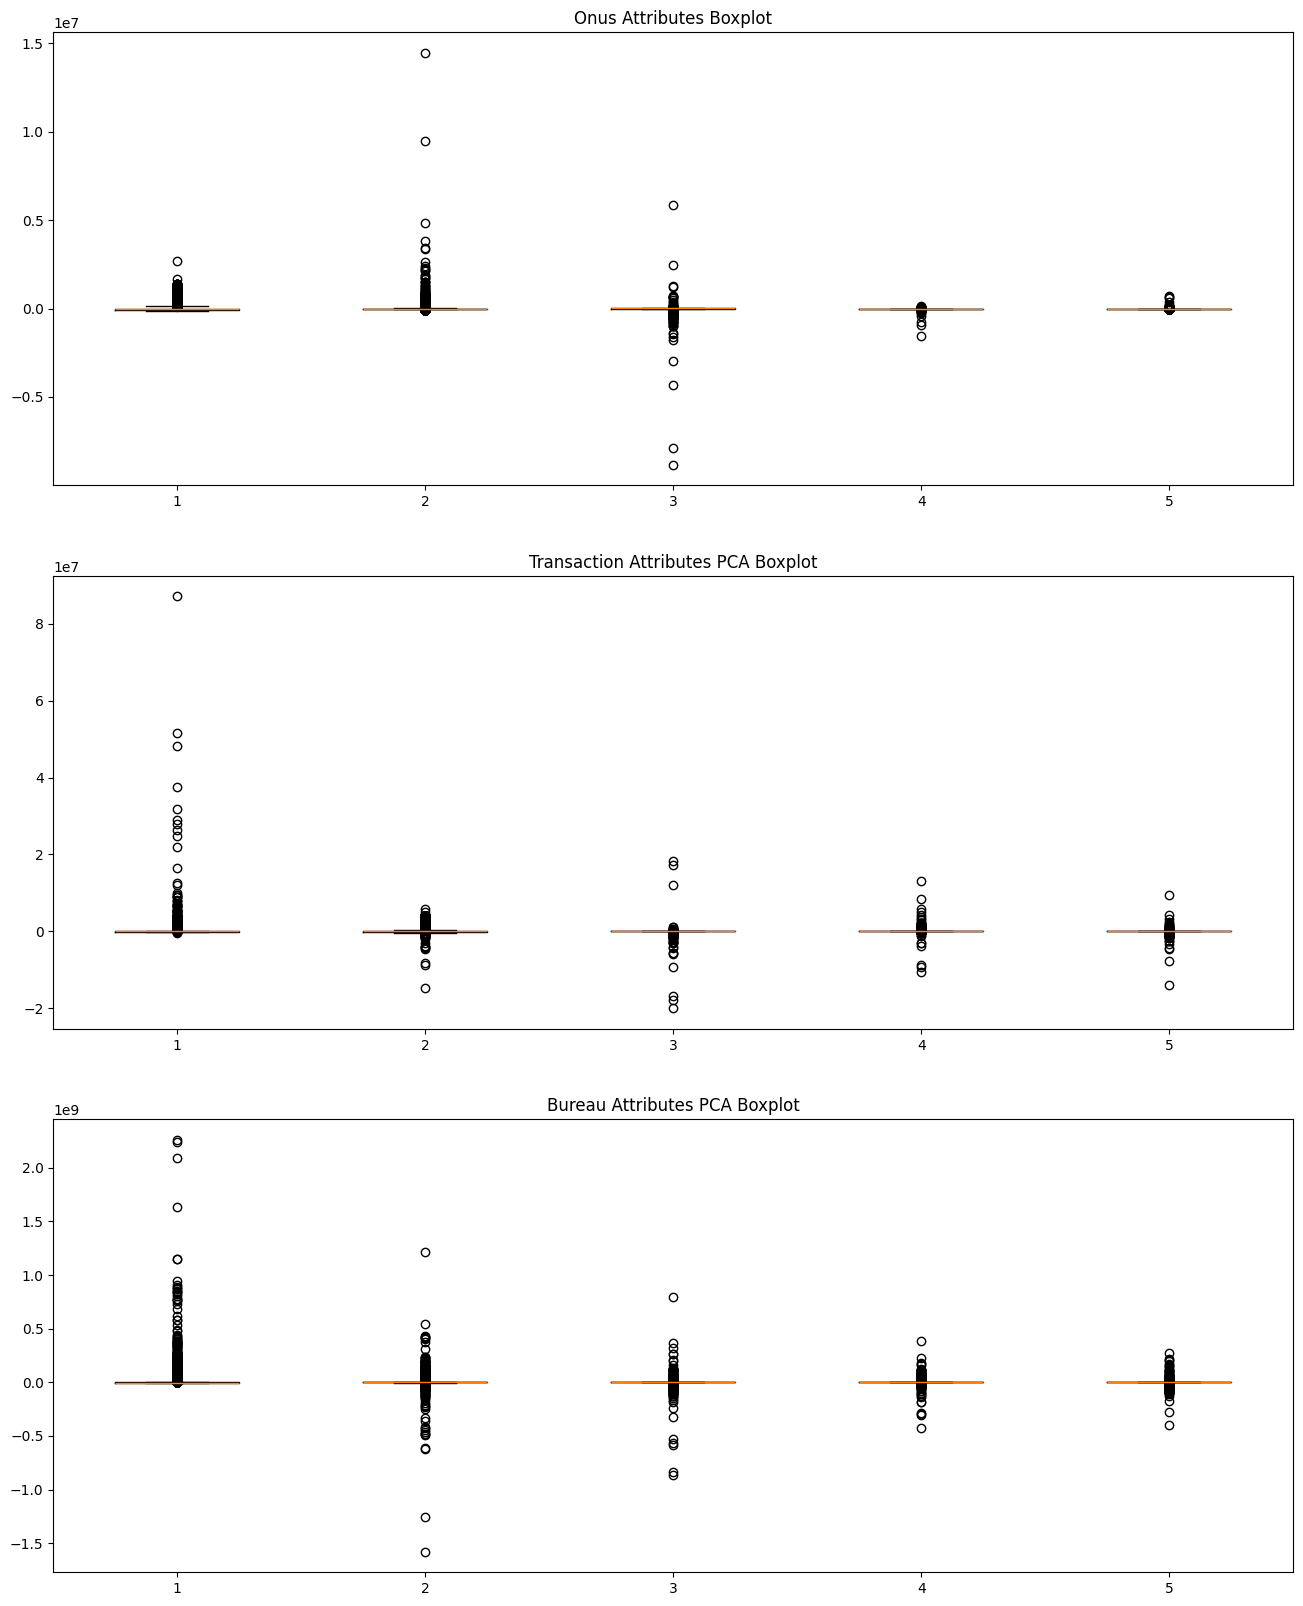

In [50]:
plt.figure(figsize=(16, 20))

# Boxplot for onus attributes
plt.subplot(3, 1, 1)
plt.boxplot(onus_attr_X_pca_df)
plt.title('Onus Attributes Boxplot')

# Boxplot for transaction attributes after PCA
plt.subplot(3, 1, 2)
plt.boxplot(transaction_attr_X_pca_df)
plt.title('Transaction Attributes PCA Boxplot')

# Boxplot for bureau attributes after PCA
plt.subplot(3, 1, 3)
plt.boxplot(bureau_attr_X_pca_df)
plt.title('Bureau Attributes PCA Boxplot')

plt.show()

In [52]:
# Calculate correlation matrix for y with PCA attributes
corr_y_pca_onus = pd.concat([y, onus_attr_X_pca_df], axis=1).corr()
corr_y_pca_transaction = pd.concat([y, transaction_attr_X_pca_df], axis=1).corr()
corr_y_pca_bureau = pd.concat([y, bureau_attr_X_pca_df], axis=1).corr()

Text(0.5, 1.0, 'Correlation Heatmap with PCA Onus Attributes and Bad Flag')

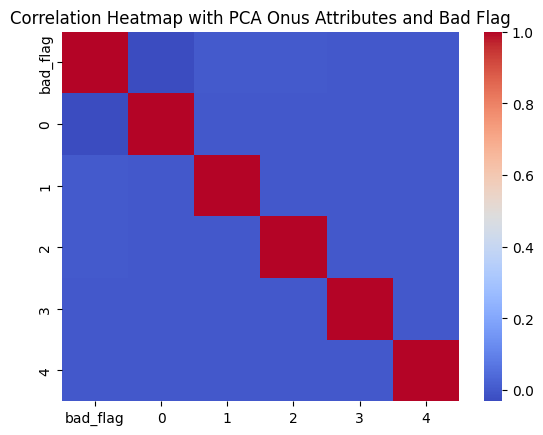

In [53]:
sns.heatmap(corr_y_pca_onus, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap with PCA Onus Attributes and Bad Flag')

Text(0.5, 1.0, 'Correlation Heatmap with PCA Transaction Attributes and Bad Flag')

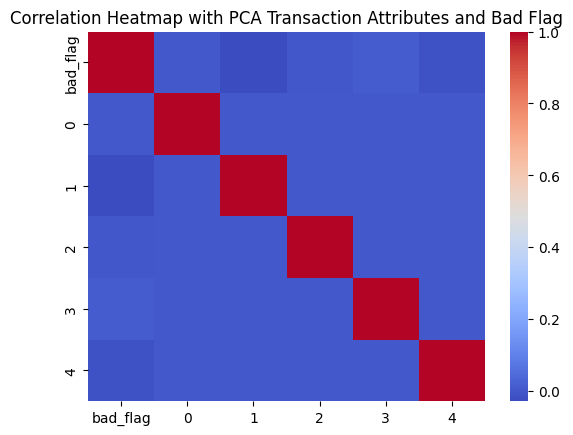

In [57]:
sns.heatmap(corr_y_pca_transaction, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap with PCA Transaction Attributes and Bad Flag')

Text(0.5, 1.0, 'Correlation Heatmap with PCA Bureau Attributes and Bad Flag')

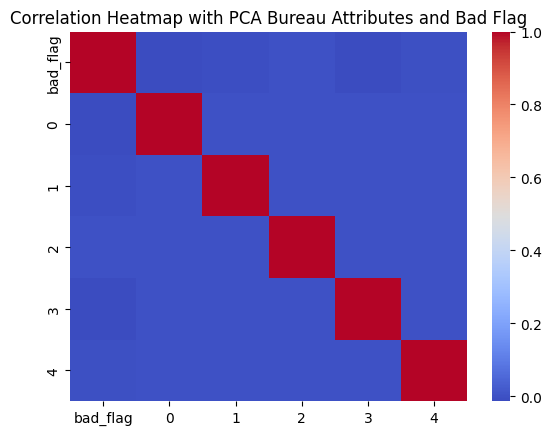

In [55]:
sns.heatmap(corr_y_pca_bureau, cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap with PCA Bureau Attributes and Bad Flag')

In [19]:
X_new = pd.DataFrame(data=np.hstack([onus_attr_X_pca_df, transaction_attr_X_pca_df, bureau_attr_X_pca_df]))
y_new = y

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X_new, y, train_size = 0.6, random_state = 42)
#Apply SMOTE
smote = SMOTE(random_state = 42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
# Check the new class distribution
print("Before SMOTE:", y_train.value_counts())
print("")
print("After SMOTE:", y_train_smote.value_counts())
print("")
print("X_train original shape:", X_train.shape)
print("")
print("X_train_smote shape:", X_train_smote.shape)

Before SMOTE: bad_flag
0    57262
1      821
Name: count, dtype: int64

After SMOTE: bad_flag
0    57262
1    57262
Name: count, dtype: int64

X_train original shape: (58083, 15)

X_train_smote shape: (114524, 15)


In [21]:
lr1 = LogisticRegression(max_iter = 1000)
lr1.fit(X_train_smote, y_train_smote)
y_pred = lr1.predict(X_test)
print(accuracy_score(y_test, y_pred))

0.29364976887121347


/Users/vedantjoshi/Documents/Python journey/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
y_pred_proba = lr1.predict_proba(X_test)[:, 1]

In [74]:
auc = roc_auc_score(y_test, y_pred_proba)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

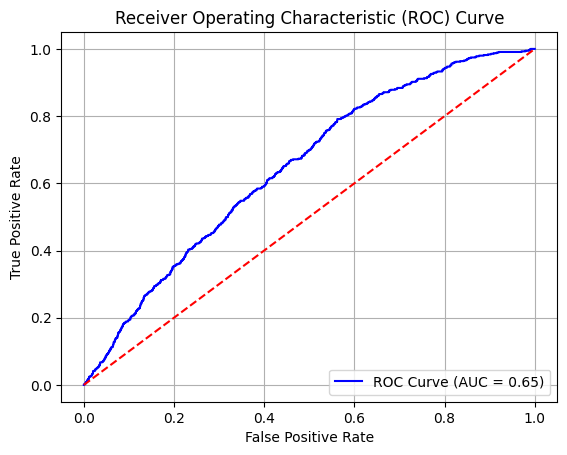

In [75]:
plt.figure()
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')
plt.grid()
plt.show()